***
**Author:** Josiah Wallis \
Created for use in CS/STAT108: Data Science Ethics (UCR - Winter 2024)
***

# Federated Learning from the bottom up
This week, we'll take a look at the difference between centralized and decentralized learning models. We'll also take a look at working with image data, a convolutional neural network, and how these elements come together to build a federated model. The goal of this discussion is not to understand every little aspect of the code, but to understand the bigger picture of what federated learning can do and how it preserves privacy. It's meant for exposure!

This notebook is meant to be covered in discussion and will not be self-contained or easily understood if read without having attended discussion. I will update the text and information in the future so the notebook can be read without the discussion.

## Note
Please run this ipython notebook in an environment where you have access to TPUs or GPUs. If you are using google colab, navigate to **Edit**, **Notebook Settings**, select **T4 GPU** then **save**.

***
# Centralized Model
A **centralized model** can be considered a model that operates in a single computing unit like a computer. Models run on your own device are typically considered centralized models as the model itself, as well as the data, are located on a single device.

In this section, we will be applying a convolutional neural network (CNN) to a classification problem: classifying handwritten images as numbers from 0 to 9.


In [2]:
# Import relevant libraries
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd

# For plotting barplots with bar count text
def better_bar(cats, heights, color: str = 'blue', ylim: bool = 'True') -> None:
  barplot = plt.bar(cats, heights, edgecolor = 'black', color = color)
  plt.xticks(cats)
  if ylim:
    plt.ylim(0.95 * np.min(heights), 1.05 * np.max(heights))

  for i, bar in enumerate(plt.bar(cats, heights)):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(heights[i]),
             ha='center', va='bottom')

Load MNIST dataset

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f'Sample/Feature shape: {X_train.shape[1:]}')
print(f'Training Samples: {X_train.shape[0]}')
print(f'Testing Samples: {X_test.shape[0]}')

total_samp = len(X_train) + len(X_test)
print(f'Train-Test Split: {len(X_train) / total_samp * 100:.0f}-{len(X_test) / total_samp * 100:.0f}')

Sample/Feature shape: (28, 28)
Training Samples: 60000
Testing Samples: 10000
Train-Test Split: 86-14


Visualize some of our sample images

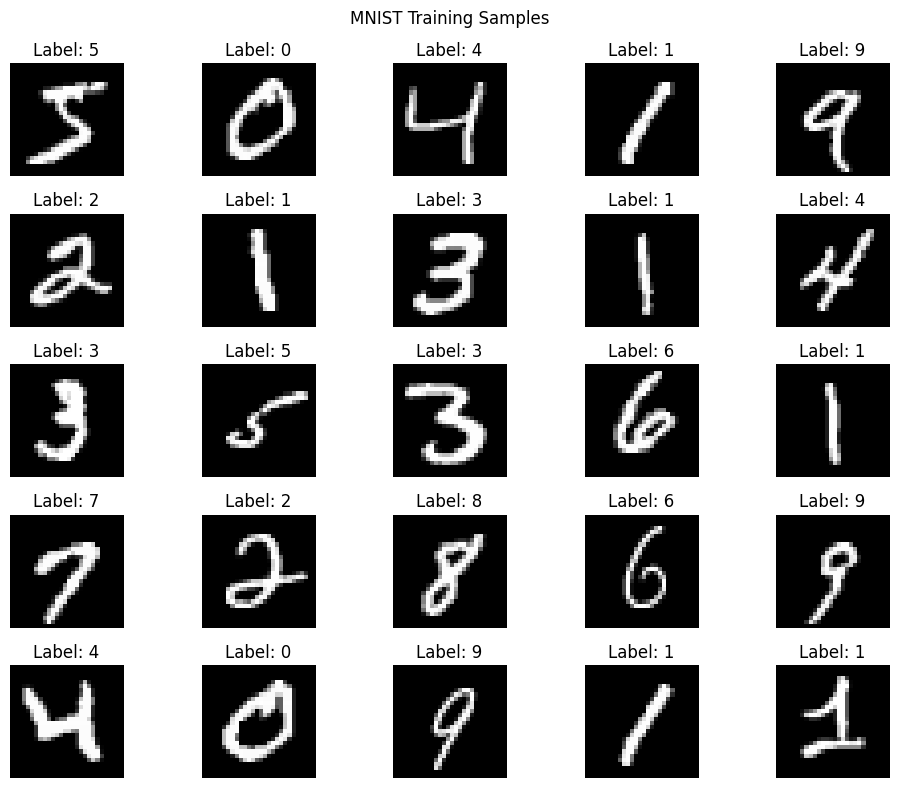

In [6]:
plt.figure(figsize = (10, 8))
for i in range(25):
  plt.subplot(5, 5, i + 1)
  plt.imshow(X_train[i], cmap = 'gray')
  plt.title(f'Label: {y_train[i]}')
  plt.axis('off')

plt.suptitle('MNIST Training Samples')
plt.tight_layout()
plt.show()

Combine data to do visualize label distribution. Note we still have variables that stored the data when it was split. After this cell, we'll have
* X_train, y_train - Training dataset (86% of total data)
* X_test, y_test - Test dataset (14% of total data)
* X, y - Whole dataset

In [5]:
X, y = np.concatenate([X_train, X_test]), np.concatenate([y_train, y_test])

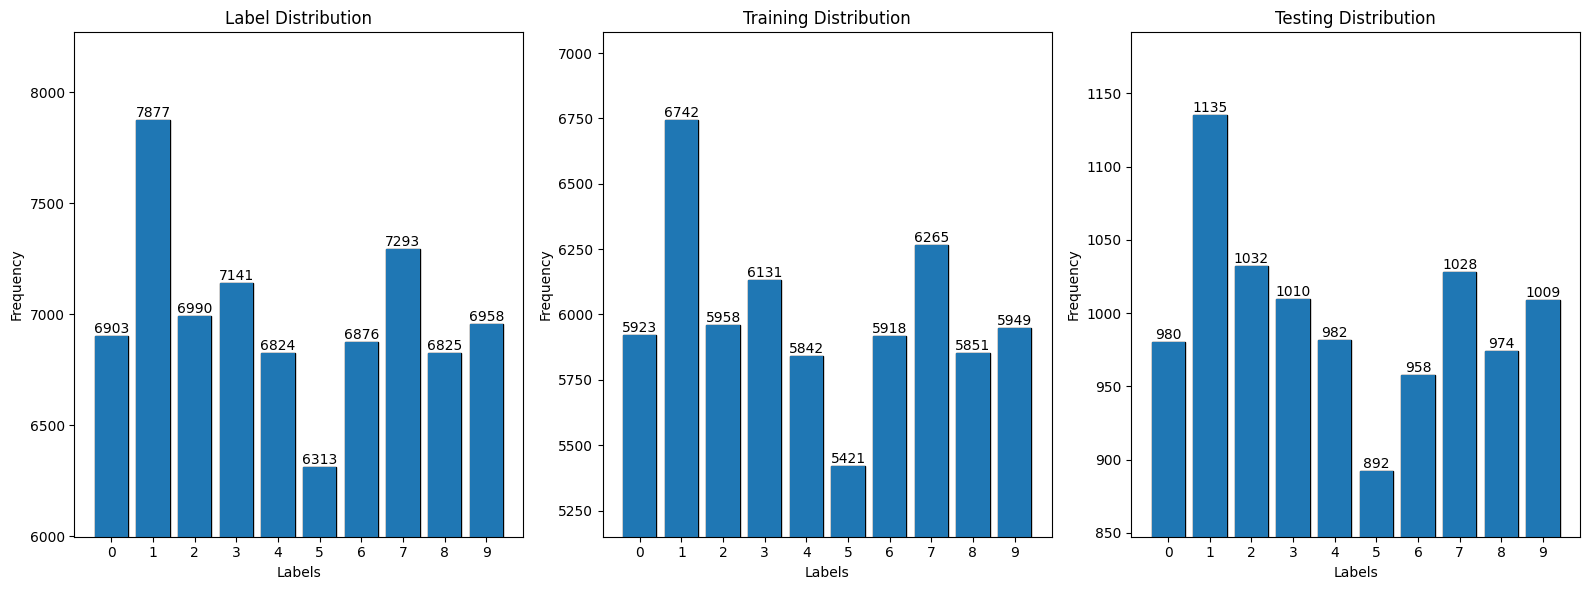

In [8]:
plt.figure(figsize = (16, 6))

plt.subplot(1, 3, 1)
better_bar(np.arange(10), np.unique(y, return_counts = True)[1])
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
better_bar(np.arange(10), np.unique(y_train, return_counts = True)[1])
plt.title('Training Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
better_bar(np.arange(10), np.unique(y_test, return_counts = True)[1])
plt.title('Testing Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

One-hot encode labels to prepare for model training

In [9]:
ohe = OneHotEncoder()
y_train_ohe = ohe.fit_transform(y_train.reshape(len(y_train), 1)).toarray()
y_test_ohe = ohe.fit_transform(y_test.reshape(len(y_test), 1)).toarray()
y_train[:5], y_train_ohe[:5]

(array([5, 0, 4, 1, 9], dtype=uint8),
 array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]))

Import neural network library

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

Create our model - a **convolutional neural network**. CNNs are computationally efficient for handling image and video data. After the network learns from the data, it will assign a vector of probabilities to a given datapoint. The index with the highest probability can be interpreted as the **predicted label**.

In [11]:
model = Sequential([
    Conv2D(4, (2, 2), activation = 'relu', input_shape = (28, 28, 1), kernel_regularizer = regularizers.l2(0.01)),
    MaxPooling2D((3, 3)),
    Flatten(),
    Dense(10, activation = 'softmax')
])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 4)         20        
                                                                 
 max_pooling2d (MaxPooling2  (None, 9, 9, 4)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 324)               0         
                                                                 
 dense (Dense)               (None, 10)                3250      
                                                                 
Total params: 3270 (12.77 KB)
Trainable params: 3270 (12.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Train the model

In [12]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train_ohe, epochs = 5)


Epoch 1/5


1875/1875 [==============================] - 8s 3ms/step - loss: 2.5207 - accuracy: 0.8390
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3089 - accuracy: 0.9307
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1838 - accuracy: 0.9469
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1526 - accuracy: 0.9537
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1381 - accuracy: 0.9582


Evaluate the model on data it's never seen before

In [13]:
test_error, test_acc = model.evaluate(X_test, y_test_ohe, verbose = 0)
print(f'Test Error: {test_error}')
print(f'Test Accuracy: {test_acc:.2%}')

Test Error: 0.12846070528030396
Test Accuracy: 96.06%


# Decentralized Model
A **decentralized model** is one that is either distributed across multiple devices, or the data it learns from is distributed across multiple devices. A **federated learning model** consists of a **central server** and **clients**. The clients train centralized models locally then send their model parameters to the central server. The central server aggregates the model parameters then distributes them back to the local models to use as starting weights for training. The final central server model, the federated model, will hopefully have learned from all the local clients - having a greater understanding of the types of data one can encounter in this domain, providing greater predictive power overall.

In [14]:
# Function for simulating client data split
def federate_data(data: np.ndarray, labels: np.ndarray, clients: int, seed = None, test_size = 0) -> tuple[list, list]:
  if seed:
    np.random.seed(seed)

  # Copy and shuffle data
  X = data.copy()
  y = labels.copy()
  shuffle_idxs = np.random.permutation(X.shape[0])
  X = X[shuffle_idxs]
  y = y[shuffle_idxs]

  # Generate test data only accessible by central server
  if test_size:
    test_idx = int(X.shape[0] * test_size)
    X_test = X[:test_idx]
    y_test = y[:test_idx]
    X = X[test_idx:]
    y = y[test_idx:]

  # Generate indices of where to split data
  idxs = np.arange(X.shape[0])
  split_idxs = np.sort(np.random.choice(idxs, clients - 1, replace = False))
  data_chunks = []
  label_chunks = []

  # Splits data up between indices
  for i in range(clients):
    if i == 0:
      data_chunk = X[:split_idxs[0]]
      label_chunk = y[:split_idxs[0]]
    elif i == len(split_idxs):
      data_chunk = X[split_idxs[-1]:]
      label_chunk = y[split_idxs[-1]:]
    else:
      data_chunk = X[split_idxs[i - 1]: split_idxs[i]]
      label_chunk = y[split_idxs[i - 1]: split_idxs[i]]

    data_chunks.append(data_chunk)
    label_chunks.append(label_chunk)

  if test_size:
    return data_chunks, label_chunks, (X_test, y_test)

  return data_chunks, label_chunks

We can check how many samples each client has

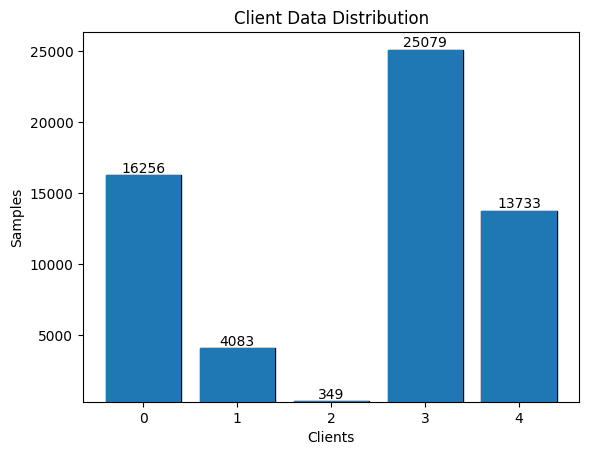

In [15]:
clients = 5
y = OneHotEncoder().fit_transform(y.reshape(len(y), 1)).toarray()
data_chunks, label_chunks, (X_test, y_test) = federate_data(X, y, clients, test_size = 0.15)

counts = []
for client in data_chunks:
  counts.append(len(client))

better_bar(np.arange(clients), counts)
plt.title('Client Data Distribution')
plt.xlabel('Clients')
plt.ylabel('Samples')
plt.show()

Let's see the distribution of test labels we'll use to test our model

Testing Samples: 10500


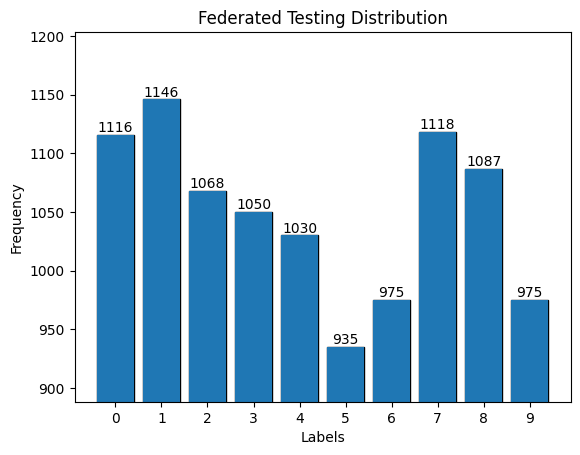

In [16]:
print(f'Testing Samples: {X_test.shape[0]}')
better_bar(np.arange(10), np.unique(np.argmax(y_test, axis = 1), return_counts = True)[1])
plt.title('Federated Testing Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()

The `Client` class will act as a container for our distributed data. It will simulate a local/centralized model, like a company who will later share their model parameters with the central server.

In [17]:
class Client():
  def __init__(self, data, labels, model = None):
    self.data = data
    self.labels = labels
    self.recent_history = None

    if not model:
      self.model = Sequential([
          Conv2D(4, (2, 2), activation = 'relu', input_shape = (28, 28, 1), kernel_regularizer = regularizers.l2(0.01)),
          MaxPooling2D((3, 3)),
          Flatten(),
          Dense(10, activation = 'softmax')
      ])
    else:
      self.model = model

  def fit(self, epochs = 5):
    self.model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    self.recent_history = self.model.fit(self.data, self.labels, epochs = epochs, verbose = 0)

  def set_weights(self, weights):
    return self.model.set_weights(weights)

  def get_weights(self):
    return self.model.get_weights()


Initialize the clients

In [18]:
clients = []
for data, labels in zip(data_chunks, label_chunks):
  new_client = Client(data, labels)
  clients.append(new_client)

Here is where we create the federated model

In [19]:
# Helper function - aggregates model parameters in a given round
def aggregate(weights):
  aggregated_weights = []

  # Takes the average of parameters in model layer i
  num_layers = len(weights[0])
  for i in range(num_layers):
    layer_weights = np.array([layer_weights[i] for layer_weights in weights])
    layer_weights = np.mean(layer_weights, axis = 0)
    aggregated_weights.append(layer_weights)

  return aggregated_weights

# Generates the federated model
def federated_model(clients, training_rounds, X_test = None, y_test = None, model = None):
  # Default architecture of our CNN
  if not model:
    global_model = Sequential([
      Conv2D(4, (2, 2), activation = 'relu', input_shape = (28, 28, 1), kernel_regularizer = regularizers.l2(0.01)),
      MaxPooling2D((3, 3)),
      Flatten(),
      Dense(10, activation = 'softmax')
    ])
  else:
    global_model = model

  # Give the model some default settings
  global_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

  # Get the starting weights for the global model before any training takes place
  curr_weights = global_model.get_weights()

  # Store global model's performance after each round
  test_accs = []

  for t in range(training_rounds):

    # Stores the parameters of each client for a given round
    client_weights = []

    for i, client in enumerate(clients):
      # Distributes global model's parameters to local client
      client.set_weights(curr_weights)

      # Train local model on local data
      client.fit()

      # Client sends central server its weights
      client_weight = client.get_weights()

      # Store the weights for aggregation
      client_weights.append(client_weight)

    # Take the average of model parameters for each layer
    curr_weights = aggregate(client_weights)

    # Load the global model with the aggregated weights
    global_model.set_weights(curr_weights)

    print(f'Finished round {t + 1}')

    if X_test is not None:
      _, test_acc = global_model.evaluate(X_test, y_test, verbose = 0)
      test_accs.append(test_acc)


  return global_model, test_accs



How well did our global model do?

In [20]:
global_model, test_accs = federated_model(clients, 3, X_test = X_test, y_test = y_test)

Finished round 1
Finished round 2
Finished round 3


In [25]:
print(test_accs)
print("testing accuracy of round 1:", test_accs[0])
print("testing accuracy of round 2:", test_accs[1])
print("testing accuracy of round 3:", test_accs[2])

[0.8479999899864197, 0.9184761643409729, 0.9532380700111389]
testing accuracy of round 1: 0.8479999899864197
testing accuracy of round 2: 0.9184761643409729
testing accuracy of round 3: 0.9532380700111389
